Loaded 500 records from ../data/processed/all_trending_2025-03-16_18-25-30.csv


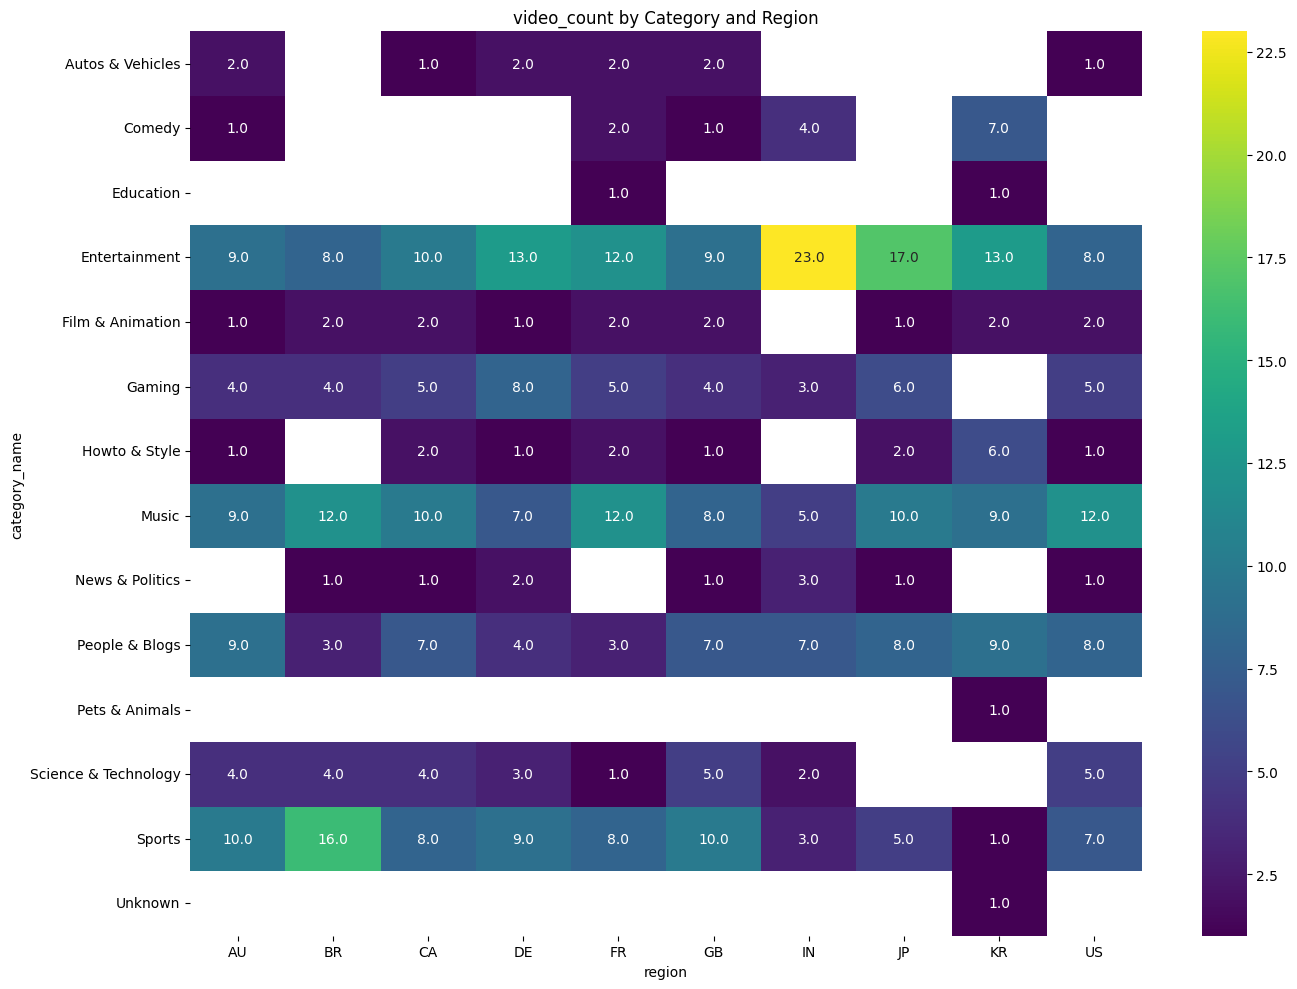

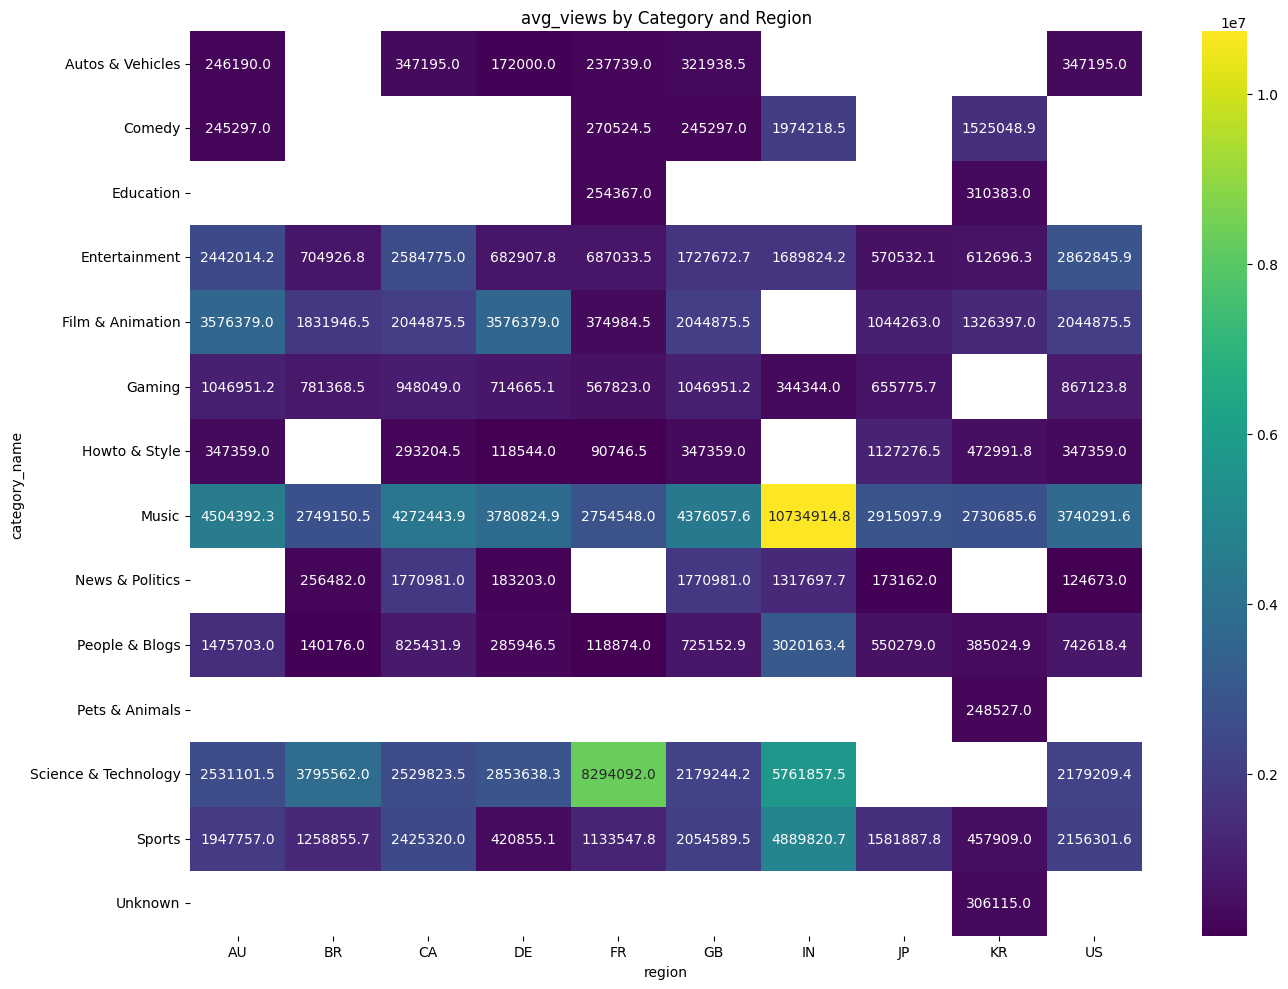

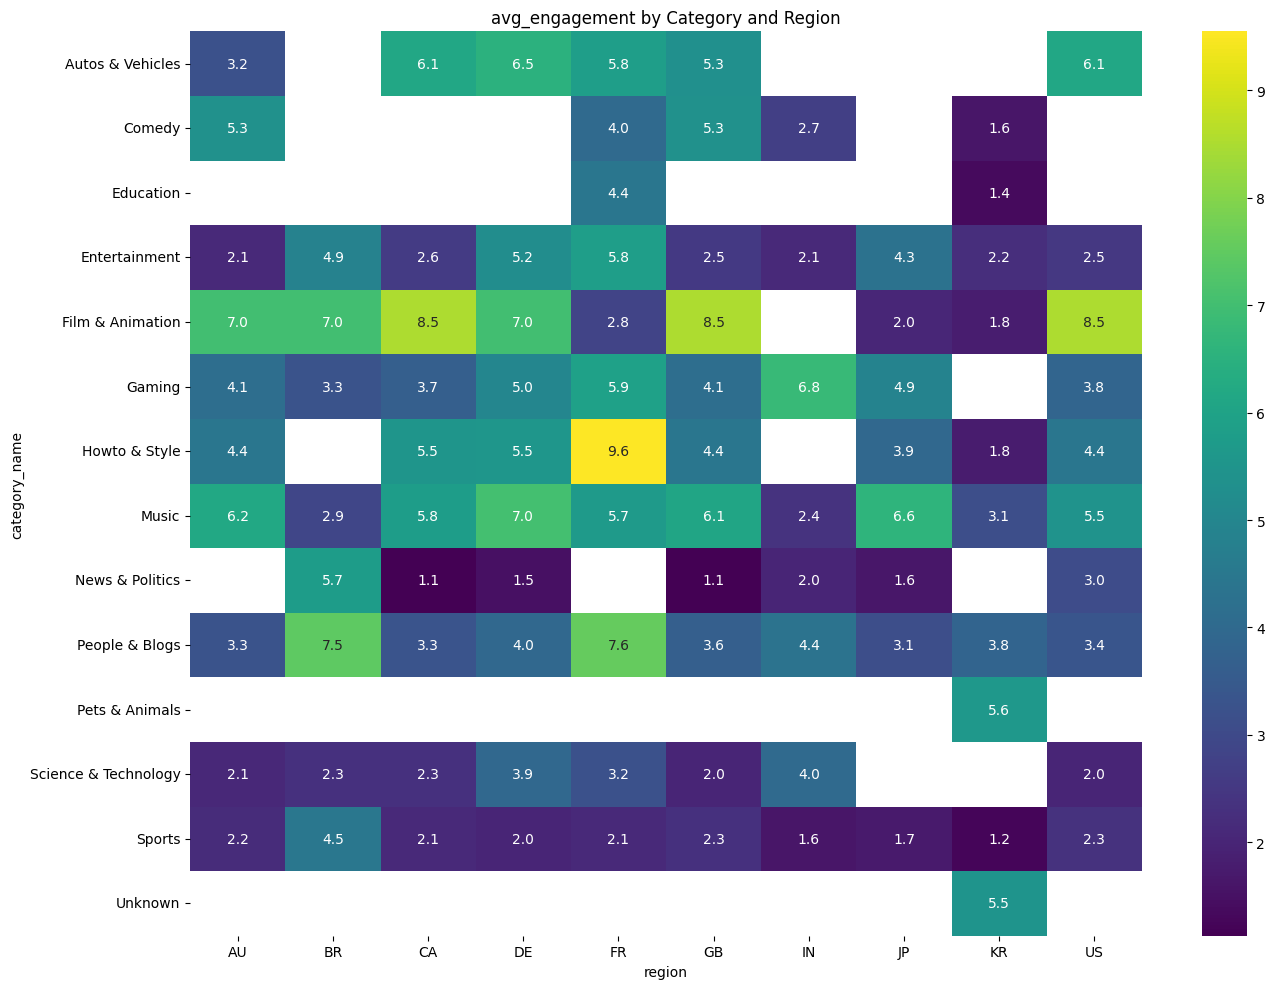

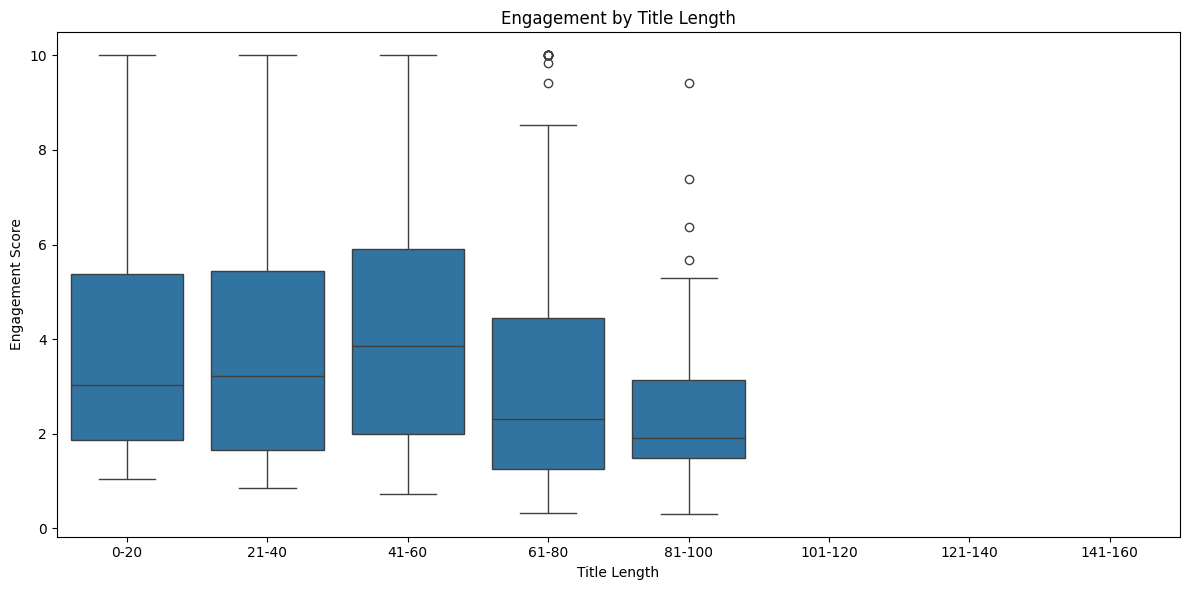

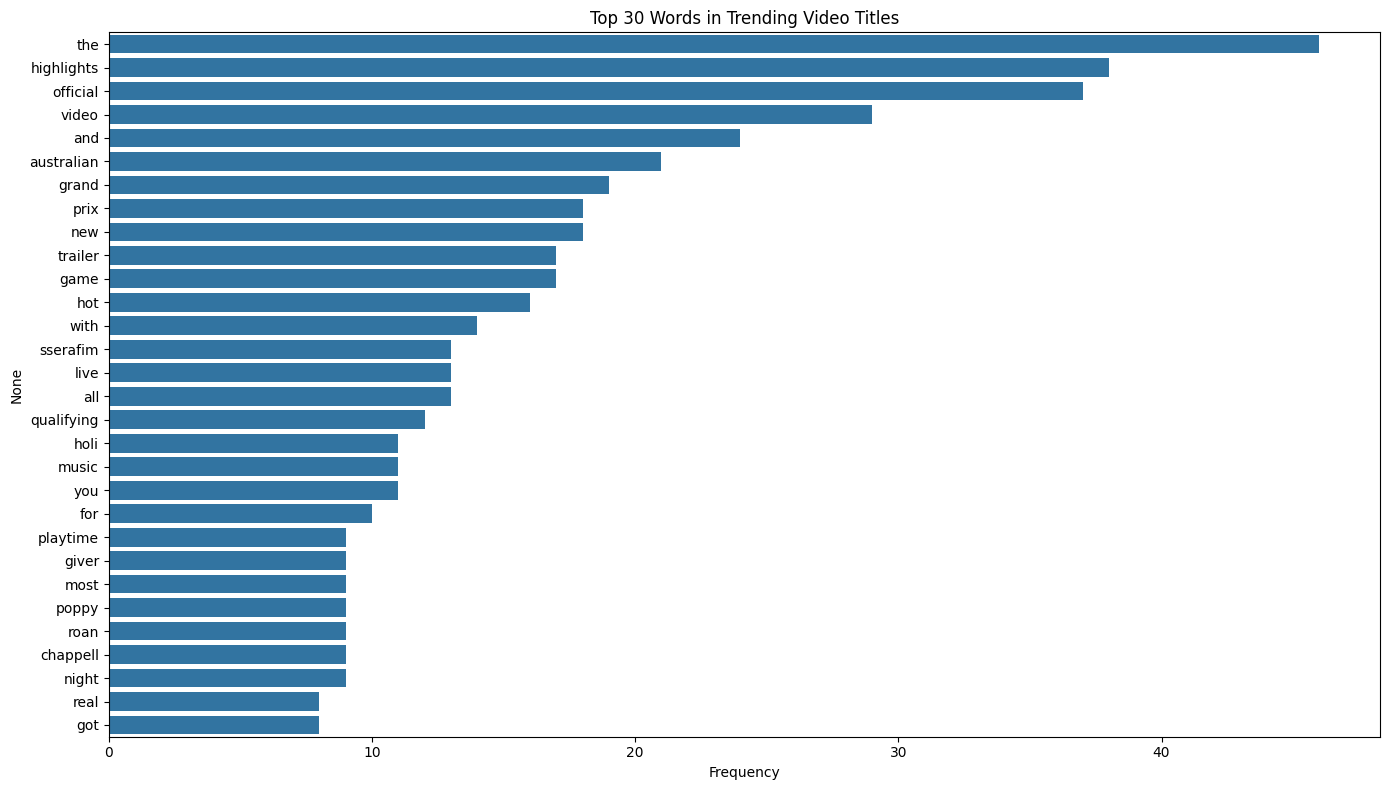

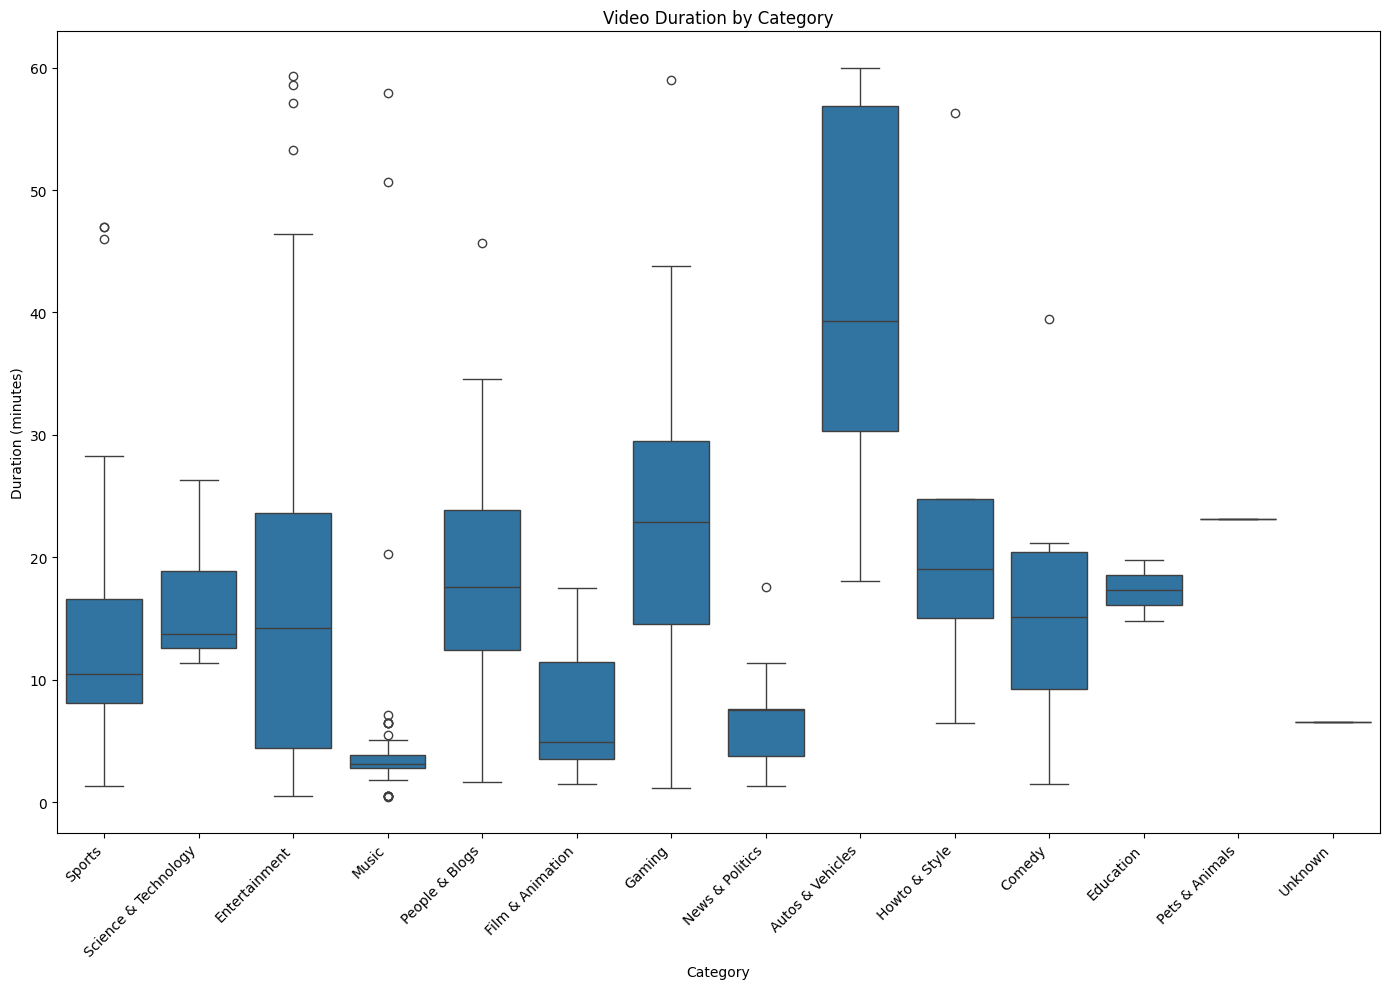

Optimal Video Duration by Category:
            category_name duration_group  engagement_score
5        Autos & Vehicles          20-30          6.380000
13                 Comedy          20-30          4.732500
20              Education          15-20          4.420000
28          Entertainment          15-20          5.192308
35       Film & Animation          10-15          7.010000
47                 Gaming          45-60          6.600000
52          Howto & Style          15-20          5.837500
56                  Music            0-2          8.672857
67        News & Politics          10-15          4.150000
73         People & Blogs            2-5         10.000000
85         Pets & Animals          20-30          5.620000
93   Science & Technology          20-30          4.470000
101                Sports          20-30          3.733000
106               Unknown           5-10          5.500000


/var/folders/w2/b7c6qmxd307bgmhlmxrjjdxm0000gn/T/ipykernel_57573/1440063291.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration_df['duration_group'] = pd.cut(duration_df['duration_minutes'],
/var/folders/w2/b7c6qmxd307bgmhlmxrjjdxm0000gn/T/ipykernel_57573/1440063291.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_engagement = duration_df.groupby(['category_name', 'duration_group'])['engagement_score'].mean().reset_index()


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import re
import sys

# Add project root to path
sys.path.append('..')

# Import custom modules
from src.data.data_processor import YouTubeDataProcessor

# Load the most recent processed data
data_dir = '../data/processed'
files = [f for f in os.listdir(data_dir) if f.startswith('all_trending_')]
if not files:
    raise ValueError("No processed data files found")

latest_file = max(files)
file_path = os.path.join(data_dir, latest_file)
df = pd.read_csv(file_path)
print(f"Loaded {len(df)} records from {file_path}")

# 1. Time-based pattern analysis
if 'publish_hour' in df.columns and 'engagement_score' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='publish_hour', y='engagement_score', ci=95)
    plt.title('Hourly Engagement Patterns')
    plt.xlabel('Hour of Day (UTC)')
    plt.ylabel('Average Engagement Score')
    plt.xticks(range(0, 24, 2))
    plt.savefig('../analysis/advanced/hourly_engagement_pattern.png')
    plt.show()

# 2. Category performance by region
if 'region' in df.columns and 'category_name' in df.columns:
    region_cat_df = df.groupby(['region', 'category_name']).agg({
        'video_id': 'count',
        'views': 'mean',
        'likes': 'mean',
        'comments': 'mean',
        'engagement_score': 'mean' if 'engagement_score' in df.columns else 'size',
    }).reset_index()
    
    region_cat_df = region_cat_df.rename(columns={
        'video_id': 'video_count',
        'views': 'avg_views',
        'likes': 'avg_likes',
        'comments': 'avg_comments',
        'engagement_score': 'avg_engagement'
    })
    
    # Plot heatmap for each metric
    metrics = ['video_count', 'avg_views', 'avg_engagement']
    
    for metric in metrics:
        plt.figure(figsize=(14, 10))
        pivot = region_cat_df.pivot(index='category_name', columns='region', values=metric)
        sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.1f')
        plt.title(f'{metric} by Category and Region')
        plt.tight_layout()
        plt.savefig(f'../analysis/advanced/heatmap_{metric}_by_region.png')
        plt.show()

# 3. Title pattern analysis
if 'title' in df.columns:
    # Extract title length
    df['title_length'] = df['title'].str.len()
    
    # Group by title length ranges
    df['title_length_group'] = pd.cut(df['title_length'], 
                                     bins=[0, 20, 40, 60, 80, 100, 120, 140, 160],
                                     labels=['0-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140', '141-160'])
    
    # Analyze engagement by title length
    if 'engagement_score' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='title_length_group', y='engagement_score')
        plt.title('Engagement by Title Length')
        plt.xlabel('Title Length')
        plt.ylabel('Engagement Score')
        plt.tight_layout()
        plt.savefig('../analysis/advanced/engagement_by_title_length.png')
        plt.show()
        
    # Word frequency analysis
    title_words = []
    for title in df['title']:
        words = re.findall(r'\b[a-zA-Z]{3,}\b', title.lower())
        title_words.extend(words)
    
    word_freq = pd.Series(title_words).value_counts()
    top_words = word_freq.head(30)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x=top_words.values, y=top_words.index)
    plt.title('Top 30 Words in Trending Video Titles')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.savefig('../analysis/advanced/title_word_frequency.png')
    plt.show()

# 4. Duration analysis by category and engagement
if 'duration_seconds' in df.columns and 'category_name' in df.columns:
    # Convert to minutes
    df['duration_minutes'] = df['duration_seconds'] / 60
    
    # Filter outliers
    duration_df = df[df['duration_minutes'] <= 60]  # Up to 1 hour
    
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=duration_df, x='category_name', y='duration_minutes')
    plt.title('Video Duration by Category')
    plt.xlabel('Category')
    plt.ylabel('Duration (minutes)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../analysis/advanced/duration_by_category.png')
    plt.show()
    
    # Optimal duration analysis
    if 'engagement_score' in df.columns:
        # Group by duration ranges
        duration_df['duration_group'] = pd.cut(duration_df['duration_minutes'], 
                                             bins=[0, 2, 5, 10, 15, 20, 30, 45, 60],
                                             labels=['0-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-45', '45-60'])
        
        # Calculate average engagement by category and duration
        duration_engagement = duration_df.groupby(['category_name', 'duration_group'])['engagement_score'].mean().reset_index()
        
        # Find optimal duration for each category
        optimal_duration = duration_engagement.loc[duration_engagement.groupby('category_name')['engagement_score'].idxmax()]
        
        print("Optimal Video Duration by Category:")
        print(optimal_duration[['category_name', 'duration_group', 'engagement_score']])

# 5. Advanced time series analysis if we have multiple collections
time_series_dir = '../data/time_series'
if os.path.exists(time_series_dir):
    time_series_files = [f for f in os.listdir(time_series_dir) if f.startswith('video_progression_')]
    
    if time_series_files:
        latest_progression = max(time_series_files)
        progression_path = os.path.join(time_series_dir, latest_progression)
        
        progression_df = pd.read_csv(progression_path)
        print(f"Loaded {len(progression_df)} video progression records")
        
        # Analyze view growth distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(progression_df['view_growth_per_hour'], bins=30, kde=True)
        plt.title('Distribution of Views Growth Rate (per hour)')
        plt.xlabel('Views per Hour')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('../analysis/advanced/view_growth_distribution.png')
        plt.show()
        
        # Analyze growth by category
        if 'category_id' in progression_df.columns:
            category_growth = progression_df.groupby('category_id').agg({
                'view_growth_per_hour': 'mean',
                'like_growth_per_hour': 'mean',
                'comment_growth_per_hour': 'mean',
                'video_id': 'count'
            }).reset_index()
            
            category_growth = category_growth.rename(columns={'video_id': 'video_count'})
            category_growth = category_growth.sort_values('view_growth_per_hour', ascending=False)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=category_growth, x='category_id', y='view_growth_per_hour')
            plt.title('Average View Growth Rate by Category')
            plt.xlabel('Category')
            plt.ylabel('Views per Hour')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('../analysis/advanced/view_growth_by_category.png')
            plt.show()